In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


In [3]:
# 1. Configuration
img_size = 128
batch_size = 16
num_classes = 7
#input_shape = (img_size, img_size, 3)
SEED = 42

In [4]:
val_path = "C:\\Users\\SATARUPA\\OneDrive\\Desktop\\Tiny ML\\Hydrophobicity Classes Photos\\train"

#it is the train dataset


In [5]:
# 2. Validation Data Generation
val_datagen = ImageDataGenerator(rescale=1./255) 
val_data = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

Found 2800 images belonging to 7 classes.


In [6]:
# Gather ALL validation images
steps = len(val_data)
X_val = []
for i in range(steps):
    X_batch, _ = val_data[i]
    X_val.append(X_batch)
X_val = np.concatenate(X_val, axis=0)

In [7]:
# 3. Load Teacher Model
teacher_model = keras.models.load_model(
    "C:/Users/SATARUPA/OneDrive/Desktop/Tiny ML/teacher_model.keras"
)


In [8]:
def mc_dropout_predict_batchwise(model, generator, n_iter=100):
    """Run Monte Carlo Dropout predictions batchwise to avoid OOM."""
    all_batch_stds = []
    for i in range(len(generator)):
        X_batch, _ = generator[i]
        preds = [model(X_batch, training=True).numpy() for _ in range(n_iter)]  # shape (n_iter, batch, classes)
        preds = np.array(preds)
        batch_std = preds.std(axis=0)  # std per sample and class
        all_batch_stds.append(batch_std)
    all_stds = np.concatenate(all_batch_stds, axis=0)
    classwise_confidence = all_stds.mean(axis=0)  # average over all samples per class
    return classwise_confidence

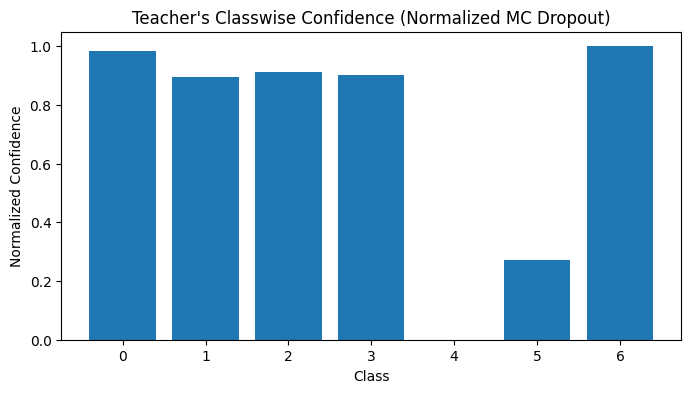

In [9]:
# Calculate uncertainty (average std) per class
classwise_uncertainty = mc_dropout_predict_batchwise(teacher_model, val_data, n_iter=100)

# Convert uncertainty to confidence
# Normalize so confidence range is between 0 and 1 for plotting
conf_min = classwise_uncertainty.min()
conf_max = classwise_uncertainty.max()
classwise_confidence = (conf_max - classwise_uncertainty) / (conf_max - conf_min)

plt.figure(figsize=(8, 4))
plt.bar(range(num_classes), classwise_confidence)
plt.xlabel("Class")
plt.ylabel("Normalized Confidence")
plt.title("Teacher's Classwise Confidence (Normalized MC Dropout)")
plt.show()



In [9]:
import numpy as np

# Assuming classwise_confidence is a numpy array
np.save('classwise_confidence.npy', classwise_confidence)
print("Confidence scores saved to classwise_confidence.npy")

NameError: name 'classwise_confidence' is not defined

In [10]:
import numpy as np

# Load the saved classwise confidence (assuming confidence range is normalized 0-1)
classwise_confidence = np.load('classwise_confidence.npy')

# Extract all validation data points and labels from your Keras generator (valdata)
alldata = []
alllabels = []
for i in range(len(val_data)):
    data_batch, label_batch = val_data[i]
    alldata.append(data_batch)
    alllabels.append(label_batch)
alldata = np.concatenate(alldata, axis=0)
alllabels = np.concatenate(alllabels, axis=0)

# If labels are one-hot encoded, convert to class indices
if alllabels.ndim == 2:
    class_indices = np.argmax(alllabels, axis=1)
else:
    class_indices = alllabels

# Define thresholds for splitting classwise confidence into 3 groups
low_threshold = np.quantile(classwise_confidence, 1/3)
high_threshold = np.quantile(classwise_confidence, 2/3)

# Determine class indices for each confidence group
low_conf_classes = np.where(classwise_confidence < low_threshold)[0]
medium_conf_classes = np.where((classwise_confidence >= low_threshold) & (classwise_confidence <= high_threshold))[0]
high_conf_classes = np.where(classwise_confidence > high_threshold)[0]

# Find indices of data points for each confidence group based on their label class
low_conf_indices = np.where(np.isin(class_indices, low_conf_classes))[0]
medium_conf_indices = np.where(np.isin(class_indices, medium_conf_classes))[0]
high_conf_indices = np.where(np.isin(class_indices, high_conf_classes))[0]

# Create subsets of data and labels
low_conf_data = alldata[low_conf_indices]
low_conf_labels = alllabels[low_conf_indices]

medium_conf_data = alldata[medium_conf_indices]
medium_conf_labels = alllabels[medium_conf_indices]

high_conf_data = alldata[high_conf_indices]
high_conf_labels = alllabels[high_conf_indices]

# Save the subsets if needed
np.save('low_conf_data.npy', low_conf_data)
np.save('low_conf_labels.npy', low_conf_labels)
np.save('medium_conf_data.npy', medium_conf_data)
np.save('medium_conf_labels.npy', medium_conf_labels)
np.save('high_conf_data.npy', high_conf_data)
np.save('high_conf_labels.npy', high_conf_labels)

print("Validation data split into 3 parts based on classwise confidence and saved.")


Validation data split into 3 parts based on classwise confidence and saved.


In [12]:
print("Classes in low confidence region:", low_conf_classes)
print("Classes in medium confidence region:", medium_conf_classes)
print("Classes in high confidence region:", high_conf_classes)


Classes in low confidence region: [4 5]
Classes in medium confidence region: [1 2 3]
Classes in high confidence region: [0 6]


In [13]:
print("Classwise confidence scores:", classwise_confidence)
print("Low threshold:", low_threshold)
print("High threshold:", high_threshold)


Classwise confidence scores: [0.9837831  0.8954117  0.9113966  0.90259296 0.         0.27220663
 1.        ]
Low threshold: 0.8954116702079773
High threshold: 0.9113966226577759


In [10]:
def mc_dropout_predict_batchwise(model, generator, n_iter=100):
    """Returns MC Dropout predictions std deviation for each data point."""
    all_samples_std = []
    for i in range(len(generator)):
        X_batch, _ = generator[i]
        preds = [model(X_batch, training=True).numpy() for _ in range(n_iter)]  # (n_iter, batch, classes)
        preds = np.array(preds)
        sample_std = preds.std(axis=0)  # std for each sample and class in batch
        # Calculate confidence per sample here as 1 - std (if you want)
        sample_confidence = 1 - sample_std.max(axis=1)  # max std among classes per sample, convert to confidence
        all_samples_std.append(sample_confidence)
    return np.concatenate(all_samples_std)

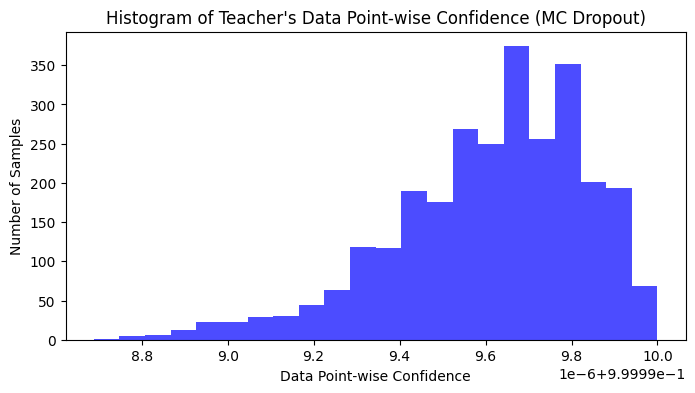

In [11]:
# Calculate data point-wise confidence values
data_point_confidence = mc_dropout_predict_batchwise(teacher_model, val_data, n_iter=100)

# Plot histogram of confidence scores
plt.figure(figsize=(8, 4))
plt.hist(data_point_confidence, bins=30, alpha=0.7, color='blue')
plt.xlabel('Data Point-wise Confidence')
plt.ylabel('Number of Samples')
plt.title("Histogram of Teacher's Data Point-wise Confidence (MC Dropout)")
plt.show()

In [12]:
import numpy as np

# Assuming data_point_confidence is a numpy array
np.save('data_point_confidence.npy', data_point_confidence)
print("Confidence scores saved to data_point_confidence.npy")


Confidence scores saved to data_point_confidence.npy


In [13]:
print("data_point_confidence scores:", data_point_confidence)

data_point_confidence scores: [0.9999995  0.9999994  0.9999994  ... 0.99999964 0.99999964 0.99999964]


In [8]:
# 4. Divide dataset into three confidence regions based on data point-wise confidence
import numpy as np

data_point_confidence = np.load('data_point_confidence.npy')
print("Confidence scores loaded")

# 2. Extract all data points and labels from your Keras generator val_data
all_data = []
all_labels = []

for i in range(len(val_data)):
    data_batch, label_batch = val_data[i]
    all_data.append(data_batch)
    all_labels.append(label_batch)

# Convert lists to numpy arrays
all_data = np.concatenate(all_data, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# 3. Define thresholds using quantiles to split dataset into three confidence regions
low_threshold = np.quantile(data_point_confidence, 1/3)
high_threshold = np.quantile(data_point_confidence, 2/3)

print(f"Low confidence threshold: {low_threshold}")
print(f"High confidence threshold: {high_threshold}")

# 4. Get indices for each confidence region
low_confidence_indices = np.where(data_point_confidence <= low_threshold)[0]
medium_confidence_indices = np.where((data_point_confidence > low_threshold) & (data_point_confidence <= high_threshold))[0]
high_confidence_indices = np.where(data_point_confidence > high_threshold)[0]

print(f"Low confidence samples count: {len(low_confidence_indices)}")
print(f"Medium confidence samples count: {len(medium_confidence_indices)}")
print(f"High confidence samples count: {len(high_confidence_indices)}")

# 5. Create subsets of data and labels for each confidence region
low_confidence_data = all_data[low_confidence_indices]
low_confidence_labels = all_labels[low_confidence_indices]

medium_confidence_data = all_data[medium_confidence_indices]
medium_confidence_labels = all_labels[medium_confidence_indices]

high_confidence_data = all_data[high_confidence_indices]
high_confidence_labels = all_labels[high_confidence_indices]







Confidence scores loaded
Low confidence threshold: 0.9999995231628418
High confidence threshold: 0.9999997019767761
Low confidence samples count: 1106
Medium confidence samples count: 879
High confidence samples count: 815


In [9]:
import numpy as np

# Save the subsets as .npy files
np.save('low_confidence_data.npy', low_confidence_data)
np.save('low_confidence_labels.npy', low_confidence_labels)

np.save('medium_confidence_data.npy', medium_confidence_data)
np.save('medium_confidence_labels.npy', medium_confidence_labels)

np.save('high_confidence_data.npy', high_confidence_data)
np.save('high_confidence_labels.npy', high_confidence_labels)

print("Subsets saved.")


Subsets saved.
